In [19]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import pandas as pd
from time import time
from mne.decoding import SlidingEstimator, cross_val_multiscore, Vectorizer
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from matplotlib import pyplot as plt
label_encoder = LabelEncoder()
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from util import EventExtractor
from scipy.interpolate import interp1d
import mne
from mne.datasets import sample
from mne.preprocessing import ICA

print(__doc__)
data_dir = 'data_meg'
subj = "R2487"
dataqual = 'prepro' #or loc/exp
exp = 'exp' #or exp
dtype = "raw"
label_dir = 'data_log'
save_dir = 'data_meg'
raw_path = f'{data_dir}/{subj}/{dataqual}/{subj}_{exp}.fif'
bad_channels_dict = {
    "R2490": ['MEG 014', 'MEG 004', 'MEG 079', 'MEG 072', 'MEG 070', 'MEG 080', 'MEG 074', 'MEG 067', 'MEG 082', 'MEG 105', 'MEG 115', 'MEG 141', 'MEG 153'],
    "R2488": ['MEG 015', 'MEG 014', 'MEG 068', 'MEG 079', 'MEG 146', 'MEG 147', 'MEG 007', 'MEG 141'],
    "R2487": ['MEG 015', 'MEG 014', 'MEG 068', 'MEG 079', 'MEG 147', 'MEG 146', 'MEG 004'],
    "R2280": ['MEG 024', 'MEG 039', 'MEG 079', 'MEG 077', 'MEG 141', 'MEG 073', 'MEG 075', 'MEG 076', 'MEG 064', 'MEG 063', 'MEG 060', 'MEG 059', 'MEG 058']
}
bad_channels = bad_channels_dict.get(subj, [])


Automatically created module for IPython interactive environment


In [ ]:
raw = mne.io.read_raw_fif(raw_path).load_data()
reject = dict(mag=5e-12, grad=4000e-13)
raw.info['bads'].extend(bad_channels)
sfreq = raw.info['sfreq']
raw.filter(1, 30, method='iir')
downsample = 10
raw.resample(sfreq / downsample)
# raw_empty_room = mne.io.read_raw_fif(f'{data_dir}/{subj}/emptyroom/{subj}_emptyroom-{dtype}.fif', preload=True)
# raw_empty_room.info['bads'].extend(bad_channels)

Effective window size : 20.480 (s)
Plotting power spectral density (dB=True).


/Users/dorisyu/opt/anaconda3/envs/meg/lib/python3.9/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


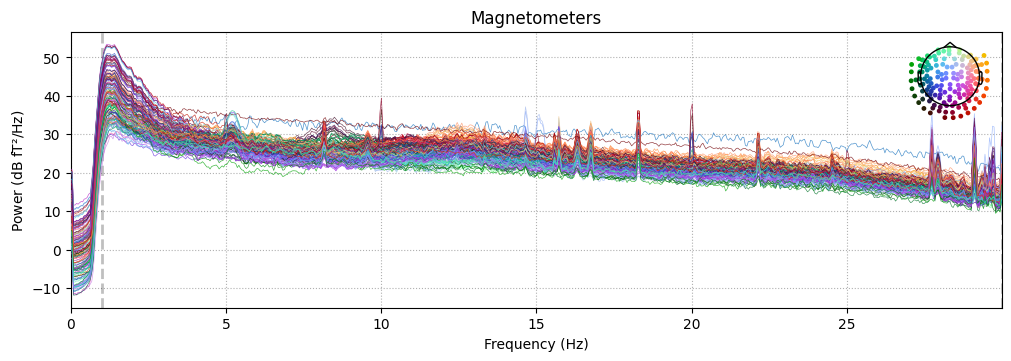

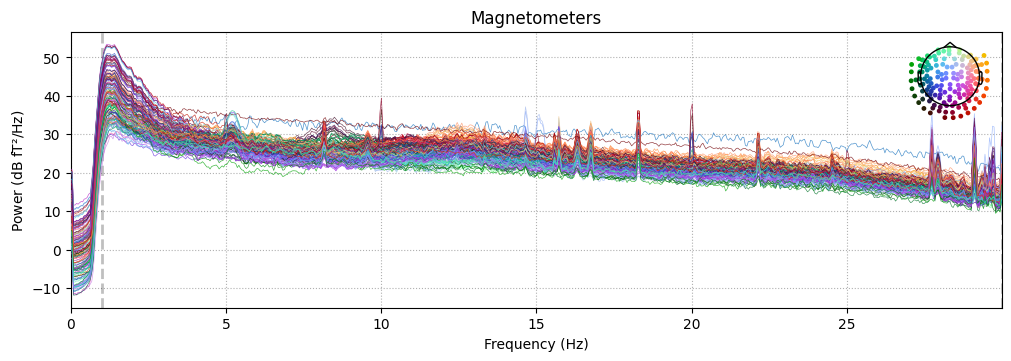

In [2]:
raw.compute_psd(fmax=30).plot(picks="data", exclude="bads", amplitude=False)

In [70]:
events = mne.find_events(raw, stim_channel='STI 014', output='onset', shortest_event=1)
event_id = {
    'start': 160,
    'move': 161,
    'reveal_red': 162,
    'reveal_white': 163,
    'done': 164,
    'choice': 165,
    'timeout': 166
}

# Define trials to remove
trials_to_remove = []
start_events = events[events[:, 2] == event_id['start']]
done_events = events[events[:, 2] == event_id['done']]
timeout_events = events[events[:, 2] == event_id['timeout']]
reveal_red_events = events[events[:, 2] == event_id['reveal_red']]
reveal_white_events = events[events[:, 2] == event_id['reveal_white']]
sfreq = raw.info['sfreq']  # Sampling frequency

# Combine 'done' and 'timeout' events
end_events = np.concatenate((done_events, timeout_events))
end_events = end_events[end_events[:, 0].argsort()] 

4629 events found on stim channel STI 014
Event IDs: [160 161 162 163 164]


In [68]:
print(len(start_events))
print(len(reveal_red_events))


240
609


In [71]:
filtered_start_events = [start_events[0]]  # Start with the first event

# Check for at least 3 seconds between each done event
for i in range(1, len(start_events)):
    time_diff = (start_events[i, 0] - start_events[i-1, 0]) / sfreq
    # if time_diff < 2:
    #     print(f"Warning: Less than 3 seconds between done events at indices {i-1} and {i}")
    
    # else:
    filtered_start_events.append(start_events[i])
start_events = filtered_start_events


In [82]:
# Initialize a list to store trial information
trial_info = []
previous_start_sample = None
processed_starts = set()
start_idx = 0
trail_t = 25
# Iterate through each start event to create trial information
for idx, start_event in enumerate(start_events):
    start_sample = start_event[0]
    
    # Find the next end event after the start event
    end_idx = np.searchsorted(end_events[:, 0], start_sample, side='right')
    end_sample = None
    while end_idx < len(end_events):
        potential_end_sample = end_events[end_idx, 0]
        if (potential_end_sample - start_sample) / sfreq <= trail_t:
            end_sample = potential_end_sample
            break
        end_idx += 1

    # If no valid end event is found, set end_sample to 26 seconds after start_sample
    if end_sample is None:
        end_sample = start_sample + int(trail_t * sfreq)
        

    # Check if the current start is at least 20 seconds after the previous start
    if (previous_start_sample is None or (start_sample - previous_start_sample) / sfreq >= 20) and start_sample not in processed_starts:
        # Proceed with processing this start event
        previous_start_sample = start_sample
        processed_starts.add(start_sample)  # Add to the set of processed starts

        # Calculate tmin and tmax for the epoch
        tmin = -0.2  # 0.2 s before 'start'
        tmax = trail_t  # Duration from 'start' to 1 s after end event
        reveal_red_within_trial = reveal_red_events[(reveal_red_events[:, 0] > start_sample) & 
                                                    (reveal_red_events[:, 0] < end_sample)]
        reveal_white_within_trial = reveal_white_events[(reveal_white_events[:, 0] > start_sample) & 
                                                        (reveal_white_events[:, 0] < end_sample)]
        # Store trial information, including whether 'reveal_red' and 'reveal_white' occurred
        trial_info.append({
            'event_sample': start_sample,
            'trial_index': start_idx,
            'duration': tmax,
            'tmin': tmin,
            'tmax': trail_t,
            'done': len(done_events) > 0,
            'start_times': start_sample / sfreq,
            'done_times': end_sample / sfreq,
            'end_sample': end_sample,
            'reveal_red': len(reveal_red_within_trial) > 0,  # Boolean flag indicating if 'reveal_red' occurred
            'reveal_red_times': (reveal_red_within_trial[:, 0] - start_sample) / sfreq if len(reveal_red_within_trial) > 0 else [],
            'reveal_white': len(reveal_white_within_trial) > 0,  # Boolean flag indicating if 'reveal_white' occurred
            'reveal_white_times': (reveal_white_within_trial[:, 0] - start_sample) / sfreq if len(reveal_white_within_trial) > 0 else [],
            'reveal_times': sorted(
                ((reveal_red_within_trial[:, 0] - start_sample) / sfreq).tolist() +
                ((reveal_white_within_trial[:, 0] - start_sample) / sfreq).tolist()
            )
        })
        start_idx += 1

In [81]:
# Combine 'done' and 'timeout' events
end_events = np.concatenate((done_events, timeout_events))
end_events = end_events[end_events[:, 0].argsort()]  # Sort by time

# Initialize a list to store trial information
trial_info = []
reveal_red_info = []
previous_start_sample = None
processed_starts = set()
start_idx = 0
trial_duration = 25  # Maximum duration of a trial in seconds

# Iterate through each start event to create trial information
for idx, start_event in enumerate(start_events):
    start_sample = start_event[0]
    
    # Find the next end event after the start event
    end_idx = np.searchsorted(end_events[:, 0], start_sample, side='right')
    end_sample = None
    while end_idx < len(end_events):
        potential_end_sample = end_events[end_idx, 0]
        if (potential_end_sample - start_sample) / sfreq <= trial_duration:
            end_sample = potential_end_sample
            break
        end_idx += 1

    # If no valid end event is found, set end_sample to the default duration
    if end_sample is None:
        end_sample = start_sample + int(trial_duration * sfreq)
    
    reveal_red_events = events[events[:, 2] == event_id['reveal_red']]
    reveal_white_events = events[events[:, 2] == event_id['reveal_white']]

    # Check if the current start is at least 20 seconds after the previous start
    if (previous_start_sample is None or (start_sample - previous_start_sample) / sfreq >= 20) and start_sample not in processed_starts:
        # Proceed with processing this start event
        previous_start_sample = start_sample
        processed_starts.add(start_sample)  # Add to the set of processed starts

        # Extract reveal_red events within the trial
        reveal_red_within_trial = reveal_red_events[
            (reveal_red_events[:, 0] > start_sample) & (reveal_red_events[:, 0] < end_sample)
        ]
        reveal_red_info.append({
            'trial_index': start_idx,
            'sequence_index': 0,
            'event_sample': start_sample,
            'time_from_start': 0.0,  # Start of the trial
            'label': 'start'
        })
        # Add sequential indices to each reveal_red event
        for seq_idx, reveal_red in enumerate(reveal_red_within_trial, start=1):
            
            reveal_red_info.append({
                'trial_index': start_idx,
                'sequence_index': seq_idx,
                'event_sample': reveal_red[0],
                'time_from_start': (reveal_red[0] - start_sample) / sfreq,
                'label': 'red',  # Label corresponding to the reveal_red event
            })

        # Extract reveal_white events within the trial
        reveal_white_within_trial = reveal_white_events[
            (reveal_white_events[:, 0] > start_sample) & (reveal_white_events[:, 0] < end_sample)
        ]

        # Store trial information
        trial_info.append({
            'event_sample': start_sample,
            'trial_index': start_idx,
            'duration': trial_duration,
            'tmin': -0.2,
            'tmax': trial_duration,
            'done': len(done_events) > 0,
            'start_times': start_sample / sfreq,
            'done_times': end_sample / sfreq,
            'reveal_red': len(reveal_red_within_trial) > 0,  # Boolean flag indicating if 'reveal_red' occurred
            'reveal_red_times': (reveal_red_within_trial[:, 0] - start_sample) / sfreq if len(reveal_red_within_trial) > 0 else [],
            'reveal_white': len(reveal_white_within_trial) > 0,  # Boolean flag indicating if 'reveal_white' occurred
            'reveal_white_times': (reveal_white_within_trial[:, 0] - start_sample) / sfreq if len(reveal_white_within_trial) > 0 else [],
            'reveal_times': sorted(
                ((reveal_red_within_trial[:, 0] - start_sample) / sfreq).tolist() +
                ((reveal_white_within_trial[:, 0] - start_sample) / sfreq).tolist()
            )
        })
        start_idx += 1

trial_info_df = pd.DataFrame(trial_info)
reveal_red_info_df = pd.DataFrame(reveal_red_info)

# # Display results
# print(trial_info_df.head())
print(reveal_red_info_df.tail())


     trial_index  sequence_index  event_sample  time_from_start label
724          119               2        302895             1.24   red
725          119               3        303303             5.32   red
726          119               4        303427             6.56   red
727          119               5        303483             7.12   red
728          119               6        303695             9.24   red


In [87]:
# Ensure epoch extraction uses the correct Raw data attributes
n_times = raw.n_times  # Total number of time points in the Raw data
sfreq = raw.info['sfreq']  # Sampling frequency
tmin = -0.5
tmax = 0.5
# Extract response-locked epochs
epochs_data = []
response_locked_info = []

for idx, event in reveal_red_info_df.iterrows():
    reveal_sample = event['event_sample']
    
    # Define start and end samples for the epoch
    start_sample = int(reveal_sample + tmin * sfreq)
    end_sample = int(reveal_sample + tmax * sfreq)
    
    # Ensure the epoch is within valid bounds
    if start_sample >= 0 and end_sample < n_times:
        picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=False, exclude='bads')
        # Extract the epoch data (channels x time points)
        epoch_data, _ = raw[picks, start_sample:end_sample]
        
        # Append the epoch data and metadata
        epochs_data.append(epoch_data)
        response_locked_info.append({
            'trial_index': event['trial_index'],
            'sequence_index': event['sequence_index'],
            'event_sample': reveal_sample,
            'epoch_start': start_sample,
            'epoch_end': end_sample,
            'time_from_start': event['time_from_start'],
            'label': event['label']
        })

# Convert epoch data to a 3D NumPy array
epochs_array = np.stack(epochs_data)  # Shape: (n_epochs, n_channels, n_time_points)

# Convert metadata to a DataFrame
response_locked_df = pd.DataFrame(response_locked_info)

# Display results
print("Response-Locked Epochs Shape:", epochs_array.shape)
print("Response-Locked Metadata:")
print(response_locked_df.tail())


Response-Locked Epochs Shape: (729, 150, 100)
Response-Locked Metadata:
     trial_index  sequence_index  event_sample  epoch_start  epoch_end  \
724          119               2        302895       302845     302945   
725          119               3        303303       303253     303353   
726          119               4        303427       303377     303477   
727          119               5        303483       303433     303533   
728          119               6        303695       303645     303745   

     time_from_start label  
724             1.24   red  
725             5.32   red  
726             6.56   red  
727             7.12   red  
728             9.24   red  


In [89]:
labels_df = pd.read_csv(f'data_log/{subj}/label.csv')
# Step 1: Get the valid trial indices
valid_trial_indices = {info['trial_index'] for info in trial_info}

# Step 2: Filter labels_df to only include valid trial indices
labels_df_filtered = labels_df[labels_df['trial_index'].isin(valid_trial_indices)]

# Create a mapping from trial_index to label using the filtered  labels_df
label_dict = dict(zip(labels_df_filtered['trial_index'], labels_df_filtered['trial.rule']))

# Step 3: Extract labels for the valid trials in trial_info_valid
y_labels = []
for info in trial_info:
    idx = info['trial_index']
    if idx in label_dict:
        y_labels.append(label_dict[idx])

y_labels = label_encoder.fit_transform(y_labels)

response_locked_df['trial_label'] = response_locked_df['trial_index'].map(label_dict)


In [91]:
# Initialize a dictionary to save cross-validation scores for all sequences
sequence_scores = {}

# Step through each sequence index
for seq_idx in range(6):  # Assuming sequence_index ranges from 0 to 5
    print(f"Training Decoder for Sequence Index {seq_idx}")
    
    # Filter data for the current sequence_index
    idx_filter = response_locked_df['sequence_index'] == seq_idx
    X_train = epochs_array[idx_filter.values]
    y_train = response_locked_df.loc[idx_filter, 'trial_label'].values
    
    if len(np.unique(y_train)) > 1:  # Ensure at least two classes for classification
        # Cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        clf = make_pipeline(StandardScaler(), LogisticRegressionCV(max_iter=1000))
        time_decoding = SlidingEstimator(clf, n_jobs=5, scoring='accuracy')
        
        # Train decoder using cross-validation
        split_scores = []  # Store accuracy for each split
        for train_idx, test_idx in cv.split(X_train, y_train):
            X_cv_train, X_cv_test = X_train[train_idx], X_train[test_idx]
            y_cv_train, y_cv_test = y_train[train_idx], y_train[test_idx]
            
            # Fit SlidingEstimator
            time_decoding.fit(X_cv_train, y_cv_train)
            
            # Predict on test set
            y_pred = time_decoding.predict(X_cv_test)  # Shape: (n_samples, n_time_points)
            
            # Compute accuracy for each time point
            time_point_accuracies = [
                accuracy_score(y_cv_test, y_pred[:, t]) for t in range(y_pred.shape[1])
            ]
            split_scores.append(time_point_accuracies)
        
        # Save the scores (shape: 5 splits x 100 time points)
        sequence_scores[seq_idx] = np.array(split_scores)
        print(f"Saved cross-validation scores for Sequence Index {seq_idx}. Shape: {sequence_scores[seq_idx].shape}")
    else:
        print(f"Skipping Sequence Index {seq_idx} (only one class present)")

import pickle
with open(f"sequence_scoresCV_{subj}.pkl", "wb") as f:
    pickle.dump(sequence_scores, f)

print(f"Cross-validation scores saved to 'sequence_scores_{subj}.pkl'.")


Training Decoder for Sequence Index 0


100%|██████████| Fitting SlidingEstimator : 100/100 [00:10<00:00,    9.39it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  679.37it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   13.58it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  776.67it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:08<00:00,   11.35it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  653.10it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   14.07it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  642.95it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   13.23it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  657.73it/s]


Saved cross-validation scores for Sequence Index 0. Shape: (5, 100)
Training Decoder for Sequence Index 1


100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   12.97it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  627.44it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   13.79it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  688.88it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   14.92it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  529.89it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   14.36it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  546.46it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   14.77it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  511.19it/s]


Saved cross-validation scores for Sequence Index 1. Shape: (5, 100)
Training Decoder for Sequence Index 2


100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   14.45it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  541.86it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   13.22it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  399.65it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:09<00:00,   10.45it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  442.93it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   12.63it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  492.90it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   13.81it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  627.49it/s]


Saved cross-validation scores for Sequence Index 2. Shape: (5, 100)
Training Decoder for Sequence Index 3


100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   13.17it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  552.07it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:08<00:00,   12.41it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  603.39it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   12.99it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  591.83it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   13.24it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  552.14it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:08<00:00,   12.15it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  540.11it/s]


Saved cross-validation scores for Sequence Index 3. Shape: (5, 100)
Training Decoder for Sequence Index 4


100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   13.78it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  643.96it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:08<00:00,   12.45it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  626.03it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   14.04it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  686.07it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:08<00:00,   11.21it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  595.21it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   13.20it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  582.22it/s]


Saved cross-validation scores for Sequence Index 4. Shape: (5, 100)
Training Decoder for Sequence Index 5


100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   16.39it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  690.67it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   15.64it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  756.30it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   15.70it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  587.01it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   16.17it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  651.18it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   16.59it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  507.77it/s]


Saved cross-validation scores for Sequence Index 5. Shape: (5, 100)
Cross-validation scores saved to 'sequence_scores.pkl'.


In [42]:
# Initialize a dictionary to save majority vote cross-validation scores for all sequences
majority_vote_scores = {}

# Step through each sequence index
for seq_idx in range(6):  # Assuming sequence_index ranges from 0 to 5
    print(f"Training Decoder for Sequence Index {seq_idx}")
    
    # Filter data for the current sequence_index
    idx_filter = response_locked_df['sequence_index'] == seq_idx
    X_train = epochs_array[idx_filter.values]
    y_train = response_locked_df.loc[idx_filter, 'trial_label'].values
    
    if len(np.unique(y_train)) > 1:  # Ensure at least two classes for classification
        # Cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        clf = make_pipeline(StandardScaler(), LogisticRegressionCV(max_iter=1000))
        time_decoding = SlidingEstimator(clf, n_jobs=5, scoring='accuracy')
        
        # Train decoder using cross-validation
        split_scores = []  # Store majority vote accuracy for each split
        for train_idx, test_idx in cv.split(X_train, y_train):
            X_cv_train, X_cv_test = X_train[train_idx], X_train[test_idx]
            y_cv_train, y_cv_test = y_train[train_idx], y_train[test_idx]
            
            # Fit SlidingEstimator
            time_decoding.fit(X_cv_train, y_cv_train)
            
            # Predict on test set
            y_pred = time_decoding.predict(X_cv_test)  # Shape: (n_samples, n_time_points)
            
            # Apply majority vote to reduce predictions across time points to a single label
            y_pred_majority = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=y_pred)
            
            # Compute accuracy using majority vote
            majority_vote_accuracy = accuracy_score(y_cv_test, y_pred_majority)
            print(f"Majority vote accuracy for Sequence Index {seq_idx}: {majority_vote_accuracy}")
            split_scores.append(majority_vote_accuracy)
        
        # Save the scores (one score per split)
        majority_vote_scores[seq_idx] = np.array(split_scores)
        print(f"Saved majority vote cross-validation scores for Sequence Index {seq_idx}. Shape: {majority_vote_scores[seq_idx].shape}")
    else:
        print(f"Skipping Sequence Index {seq_idx} (only one class present)")

# Save the data for visualization or further analysis
with open(f"majority_vote_{subj}.pkl", "wb") as f:
    pickle.dump(majority_vote_scores, f)

print("Majority vote cross-validation scores saved to 'majority_vote_scores.pkl'.")


Training Decoder for Sequence Index 0


100%|██████████| Fitting SlidingEstimator : 100/100 [00:12<00:00,    7.97it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  788.15it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:09<00:00,   10.31it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  665.02it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:13<00:00,    7.42it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  610.15it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:11<00:00,    8.46it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  643.32it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:09<00:00,   10.50it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  726.87it/s]


Saved majority vote cross-validation scores for Sequence Index 0. Shape: (5,)
Training Decoder for Sequence Index 1


100%|██████████| Fitting SlidingEstimator : 100/100 [00:09<00:00,   10.54it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  629.51it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:10<00:00,    9.97it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  649.76it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:08<00:00,   12.31it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  695.63it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:08<00:00,   11.33it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  590.24it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:08<00:00,   12.26it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  582.81it/s]


Saved majority vote cross-validation scores for Sequence Index 1. Shape: (5,)
Training Decoder for Sequence Index 2


100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   12.64it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  692.89it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   13.40it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  654.85it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:08<00:00,   11.59it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  579.01it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:08<00:00,   12.37it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  732.59it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   13.99it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  697.11it/s]


Saved majority vote cross-validation scores for Sequence Index 2. Shape: (5,)
Training Decoder for Sequence Index 3


100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   15.68it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  603.84it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   15.04it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  593.55it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   14.99it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  634.61it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   15.77it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  694.63it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   15.52it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  579.88it/s]


Saved majority vote cross-validation scores for Sequence Index 3. Shape: (5,)
Training Decoder for Sequence Index 4


100%|██████████| Fitting SlidingEstimator : 100/100 [00:05<00:00,   17.13it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  721.50it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   15.85it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  647.28it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   15.58it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  749.13it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:05<00:00,   17.11it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  700.18it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:05<00:00,   17.05it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  746.06it/s]


Saved majority vote cross-validation scores for Sequence Index 4. Shape: (5,)
Training Decoder for Sequence Index 5


100%|██████████| Fitting SlidingEstimator : 100/100 [00:05<00:00,   17.43it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  535.92it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:05<00:00,   16.95it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  605.98it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   16.15it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  633.09it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:05<00:00,   17.35it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  770.13it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:05<00:00,   18.07it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  694.27it/s]


Saved majority vote cross-validation scores for Sequence Index 5. Shape: (5,)
Majority vote cross-validation scores saved to 'majority_vote_scores.pkl'.


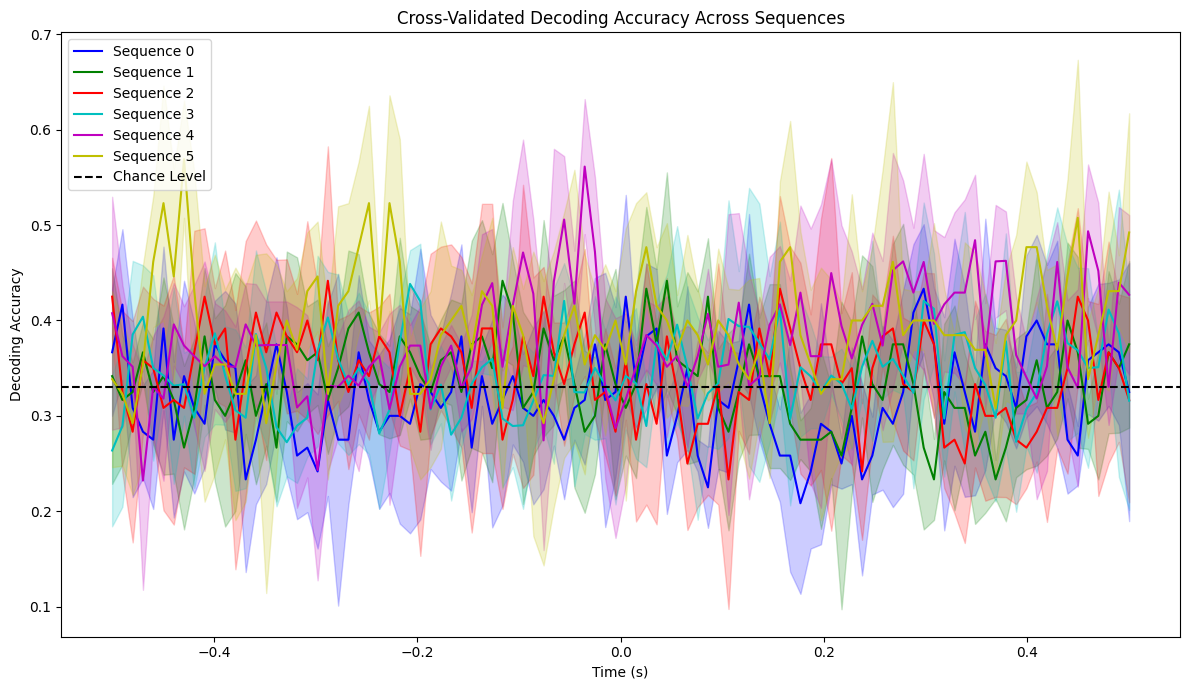

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Load the saved sequence_scores
with open(f"sequence_scoresCV_{subj}.pkl", "rb") as f:
    sequence_scores = pickle.load(f)

# Time axis (adjust based on the actual time points in your data)
n_time_points = next(iter(sequence_scores.values())).shape[1]
time_axis = np.linspace(-0.5, 0.5, n_time_points)  # Example: -0.5 to 1.0 seconds

# Plot cross-validation results for each sequence index
plt.figure(figsize=(12, 7))
colors = ['b', 'g', 'r', 'c', 'm', 'y']  # Colors for each sequence index

for seq_idx, scores in sequence_scores.items():
    mean_scores = np.mean(scores, axis=0)  # Mean accuracy across splits
    std_scores = np.std(scores, axis=0)  # Standard deviation across splits
    
    # Plot mean accuracy with shaded error region
    plt.plot(time_axis, mean_scores, label=f"Sequence {seq_idx}", color=colors[seq_idx % len(colors)])
    plt.fill_between(time_axis, mean_scores - std_scores, mean_scores + std_scores, alpha=0.2, color=colors[seq_idx % len(colors)])

# Customize the plot
plt.axhline(0.33, color='k', linestyle='--', label='Chance Level')  # Chance level
plt.xlabel("Time (s)")
plt.ylabel("Decoding Accuracy")
plt.title("Cross-Validated Decoding Accuracy Across Sequences")
plt.legend()
plt.tight_layout()
plt.show()
